In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch import Tensor
import glob
import natsort
import numpy as np
import imageio
import matplotlib.pyplot as plt
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
import h5py
import pytorch_lightning as pl

In [2]:
batch_size = 32

#### Load the data

In [3]:
hf = h5py.File("Brats2018_training_data_sep_channels_train_val_mix.h5", 'r')
train_data = hf['data'][()]     #`data` is now an ndarray
hf.close()

hf = h5py.File("Brats2018_training_data_sep_channels_train_val_mix.h5", 'r')
train_labels = hf['label'][()]     #`data` is now an ndarray
hf.close()

hf = h5py.File("Brats2018_validation_data_sep_channels_train_val_mix.h5", 'r')
val_data = hf['data'][()]     #`data` is now an ndarray
hf.close()

hf = h5py.File("Brats2018_validation_data_sep_channels_train_val_mix.h5", 'r')
val_labels = hf['label'][()]     #`data` is now an ndarray
hf.close()

In [4]:
len(train_data)

8500

In [5]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)

(8500, 4, 240, 240)
(8500, 3, 240, 240)
(1153, 4, 240, 240)
(1153, 3, 240, 240)


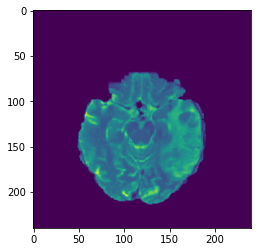

In [6]:
plt.imshow(train_data[1100,1,])

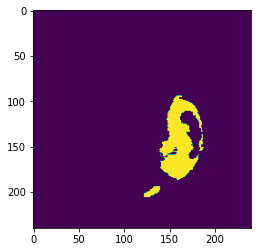

In [7]:
plt.imshow(train_labels[1100,1,])

In [8]:
for i in range(len(train_data)):
    for j in range(4):
        train_data[i,j,:,:] =(train_data[i,j,:,:] - np.min(train_data[i,j,:,:])) / (np.max(train_data[i,j,:,:]) - np.min(train_data[i,j,:,:]))
        
        
for i in range(len(val_data)):
    for j in range(4):
        val_data[i,j,:,:] =(val_data[i,j,:,:] - np.min(val_data[i,j,:,:])) / (np.max(val_data[i,j,:,:]) - np.min(val_data[i,j,:,:]))

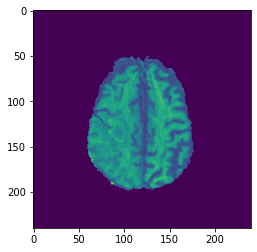

In [9]:
plt.imshow(train_data[0,0,:,:])

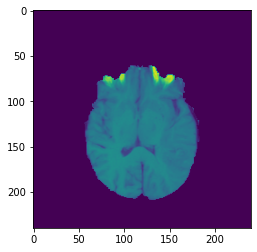

In [10]:
plt.imshow(val_data[0,0,:,:])

#### convert the training and validation data into Pytorch tensor

In [11]:
#do it for the training data
train_t1_tensor = torch.from_numpy(train_data[:,0,:,:]).float()
train_t1_tensor = train_t1_tensor[:, None, :, :]

train_t2_tensor = torch.from_numpy(train_data[:,1,:,:]).float()
train_t2_tensor = train_t2_tensor[:, None, :, :]

train_t1ce_tensor = torch.from_numpy(train_data[:,2,:,:]).float()
train_t1ce_tensor = train_t1_tensor[:, None, :, :]

train_flair_tensor = torch.from_numpy(train_data[:,3,:,:]).float()
train_flair_tensor = train_flair_tensor[:, None, :, :]

train_label_tensor = torch.from_numpy(train_labels).float()


#do it for the validation data
val_t1_tensor = torch.from_numpy(val_data[:,0,:,:]).float()
val_t1_tensor = val_t1_tensor[:, None, :, :]

val_t2_tensor = torch.from_numpy(val_data[:,1,:,:]).float()
val_t2_tensor = val_t2_tensor[:, None, :, :]

val_t1ce_tensor = torch.from_numpy(val_data[:,2,:,:]).float()
val_t1ce_tensor = val_t1ce_tensor[:, None, :, :]

val_flair_tensor = torch.from_numpy(val_data[:,3,:,:]).float()
val_flair_tensor = val_flair_tensor[:, None, :, :]

val_label_tensor = torch.from_numpy(val_labels).float()


#do it for the training data
train_data_tensor = torch.from_numpy(train_data).float()
train_label_tensor = torch.from_numpy(train_labels).float()

val_data_tensor = torch.from_numpy(val_data).float()
val_label_tensor = torch.from_numpy(val_labels).float()

In [12]:
print(train_data_tensor.shape)
print(train_label_tensor.shape)
print(val_data_tensor.shape)
print(val_label_tensor.shape)

torch.Size([8500, 4, 240, 240])
torch.Size([8500, 3, 240, 240])
torch.Size([1153, 4, 240, 240])
torch.Size([1153, 3, 240, 240])


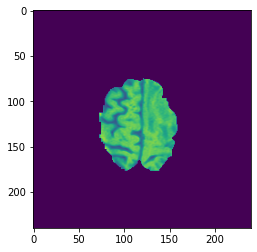

In [13]:
plt.imshow(train_data_tensor[5,0,:,:])

In [14]:
np.unique(train_labels[5,0,:,:])

array([0, 1], dtype=uint8)

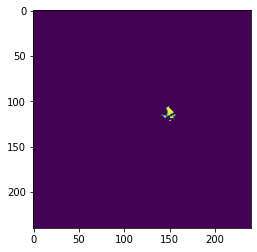

In [15]:
plt.imshow(train_label_tensor[5,0,:,:])

In [27]:
#define the network
class fuse_model(nn.Module):
    def  __init__(self):
        super(fuse_model, self).__init__()
        #fusion
        self.fuse = nn.Sequential( #input shape (,4,240,240)
                         nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(32),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.Conv2d(in_channels  = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
                         ) #output shape (,1,240,240)   
 
        
    def forward(self, x):
        #fuse
        fuse1 = self.fuse(x)
        #tanh 
        fuse2 = torch.tanh(fuse1)
        return fuse2
        #execute the network

In [31]:
# Generate the model.
model = fuse_model().to(DEVICE)
model = model.float()

#define the optimizers and loss functions 
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)   # optimize all cnn parameters
l2_loss   = nn.MSELoss() #MSEloss

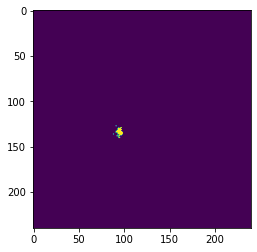

In [32]:
plt.imshow(train_label_tensor[0,0,:,:])

In [33]:
total_train_images = 8500
total_val_images = 1153

counter = 0
counter_val = 0 
EPOCHS = 200
lamda_ssim_t1 = 0.42
lamda_ssim_t2 = 0.7
lamda_ssim_t1t2 = 0.4
lamda_l2_t1 = 0.1
lamda_l2_t2 = 0.3
lamda_l2_t1t2 = 0.5
lamda_fusion = 0.99

loss_train = []
loss_ssim_train_t1 = []
loss_ssim_train_t2 = []
loss_ssim_train_t1ce = []
loss_ssim_train_flair = []
loss_l2_train_t1 = []
loss_l2_train_t2 = []
loss_l2_train_t1ce = []
loss_l2_train_flair = []

loss_val = []
loss_ssim_val_t1 = []
loss_ssim_val_t2 = []
loss_ssim_val_t1ce = []
loss_ssim_val_flair = []
loss_l2_val_t1 = []
loss_l2_val_t2 = []
loss_l2_val_t1ce = []
loss_l2_val_flair = []

ep_train_loss = []
ep_ssim_train_loss_t1 = []
ep_ssim_train_loss_t2 = []
ep_ssim_train_loss_t1ce = []
ep_ssim_train_loss_flair = []
ep_l2_train_loss_t1 = []
ep_l2_train_loss_t2 = []
ep_l2_train_loss_t1ce = []
ep_l2_train_loss_flair = []

ep_val_loss = []
ep_ssim_val_loss_t1 = []
ep_ssim_val_loss_t2 = []
ep_ssim_val_loss_t1ce = []
ep_ssim_val_loss_flair = []
ep_l2_val_loss_t1 = []
ep_l2_val_loss_t2 = []
ep_l2_val_loss_t1ce = []
ep_l2_val_loss_flair = []

# Training of the model
for epoch in range(EPOCHS):
    
    model.train()
    # run batch images
    batch_idxs = total_train_images // batch_size
    for idx in range(0, batch_idxs):
        counter += 1
        input_  = train_data_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(DEVICE)
        
        fused = model(input_)
        
        #SSIM loss for the fusion training
        ssim_loss_t1    = 1 - ssim(fused, input_[:,0:1,:,:],data_range=1)
        ssim_loss_t2    = 1 - ssim(fused, input_[:,1:2,:,:],data_range=1)
        ssim_loss_t1ce  = 1 - ssim(fused, input_[:,2:3,:,:],data_range=1)
        ssim_loss_flair = 1 - ssim(fused, input_[:,3:4,:,:],data_range=1)
        #club the T1 ssim losses
        ssim_loss_t1_combined = lamda_ssim_t1 * ssim_loss_t1 + (1-lamda_ssim_t1) * ssim_loss_t1ce
        #club the T2 ssim losses
        ssim_loss_t2_combined = lamda_ssim_t2 * ssim_loss_t2 + (1-lamda_ssim_t2) * ssim_loss_flair
        #combine all ssim loss
        ssim_loss_combined    = lamda_ssim_t1t2 * ssim_loss_t1_combined + (1-lamda_ssim_t1t2) * ssim_loss_t2_combined
        
        #l2 loss for the fusion training
        l2_loss_t1    = l2_loss(fused, input_[:,0:1,:,:])
        l2_loss_t2    = l2_loss(fused, input_[:,1:2,:,:])
        l2_loss_t1ce  = l2_loss(fused, input_[:,2:3,:,:])
        l2_loss_flair = l2_loss(fused, input_[:,3:4,:,:])        
        #club the T1 l2 losses
        l2_loss_t1_combined = lamda_l2_t1 * l2_loss_t1 + (1-lamda_l2_t1) * l2_loss_t1ce
        #club the T2 l2 losses
        l2_loss_t2_combined = lamda_l2_t2 * l2_loss_t2 + (1-lamda_l2_t2) * l2_loss_flair
        #combine all l2 losses
        l2_loss_combined    = lamda_l2_t1t2 * l2_loss_t1_combined + (1-lamda_l2_t1t2) * l2_loss_t2_combined
        
        
        #combine ssim_l2_loss
        fusion_loss_total = lamda_fusion * ssim_loss_combined +  (1-lamda_fusion) * l2_loss_combined
        
        
        optimizer.zero_grad()
        fusion_loss_total.backward()
        optimizer.step()
        
        
        if counter % 100 == 0:
            print("Epoch: [%2d],step: [%2d], train_total_loss: [%.8f], train_ssim_t1_loss: [%.8f], train_ssim_t2_loss: [%.8f], train_ssim_t1ce_loss: [%.8f], train_ssim_flair_loss: [%.8f], train_l2_t1_loss: [%.8f], train_l2_t2_loss: [%.8f], train_l2_t1ce_loss: [%.8f], train_l2_flair_loss: [%.8f]" 
                  %(epoch, counter, fusion_loss_total, ssim_loss_t1, ssim_loss_t2, ssim_loss_t1ce, ssim_loss_flair, l2_loss_t1, l2_loss_t2, l2_loss_t1ce, l2_loss_flair))
            
        #store the training loss value at each epoch
        loss_train.append(fusion_loss_total.item())
        loss_ssim_train_t1.append(ssim_loss_t1.item())
        loss_ssim_train_t2.append(ssim_loss_t2.item())
        loss_ssim_train_t1ce.append(ssim_loss_t1ce.item())
        loss_ssim_train_flair.append(ssim_loss_flair.item())
        loss_l2_train_t1.append(l2_loss_t1.item())
        loss_l2_train_t2.append(l2_loss_t2.item())
        loss_l2_train_t1ce.append(l2_loss_t1ce.item())
        loss_l2_train_flair.append(l2_loss_flair.item())
        
        
    av_train_loss = np.average(loss_train)
    ep_train_loss.append(av_train_loss)
    
    av_ssim_train_loss_t1 = np.average(loss_ssim_train_t1)
    ep_ssim_train_loss_t1.append(av_ssim_train_loss_t1)
    av_l2_train_loss_t1 = np.average(loss_l2_train_t1)
    ep_l2_train_loss_t1.append(av_l2_train_loss_t1)
    
    av_ssim_train_loss_t2 = np.average(loss_ssim_train_t2)
    ep_ssim_train_loss_t2.append(av_ssim_train_loss_t2)
    av_l2_train_loss_t2 = np.average(loss_l2_train_t2)
    ep_l2_train_loss_t2.append(av_l2_train_loss_t2)
    
    av_ssim_train_loss_t1ce = np.average(loss_ssim_train_t1ce)
    ep_ssim_train_loss_t1ce.append(av_ssim_train_loss_t1ce)
    av_l2_train_loss_t1ce = np.average(loss_l2_train_t1ce)
    ep_l2_train_loss_t1ce.append(av_l2_train_loss_t1ce)
    
    av_ssim_train_loss_flair = np.average(loss_ssim_train_flair)
    ep_ssim_train_loss_flair.append(av_ssim_train_loss_flair)
    av_l2_train_loss_flair = np.average(loss_l2_train_flair)
    ep_l2_train_loss_flair.append(av_l2_train_loss_flair)
    
    
    #Validation of the model.
    model.eval()
    batch_idxs_val = total_val_images // batch_size
    with torch.no_grad():
        for idx in range(0, batch_idxs_val):
            counter_val += 1
            input_val  = val_data_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(DEVICE)
                
            fused_val = model(input_val)
            
            ssim_loss_t1_val = 1 - ssim(fused_val, input_val[:,0:1,:,:],data_range=1)
            ssim_loss_t2_val = 1 - ssim(fused_val, input_val[:,1:2,:,:],data_range=1)
            ssim_loss_t1ce_val = 1 - ssim(fused_val, input_val[:,2:3,:,:],data_range=1)
            ssim_loss_flair_val = 1 - ssim(fused_val, input_val[:,3:4,:,:],data_range=1)
            #club the T1 ssim losses
            ssim_loss_t1_combined_val = lamda_ssim_t1 * ssim_loss_t1_val + (1-lamda_ssim_t1) * ssim_loss_t1ce_val
            #club the T2 ssim losses
            ssim_loss_t2_combined_val = lamda_ssim_t2 * ssim_loss_t2_val + (1-lamda_ssim_t2) * ssim_loss_flair_val
            #combine all ssim loss
            ssim_loss_combined_val    = lamda_ssim_t1t2 * ssim_loss_t1_combined_val + (1-lamda_ssim_t1t2) * ssim_loss_t2_combined_val            

            
            #l2 loss for the fusion training
            l2_loss_t1_val    = l2_loss(fused_val, input_val[:,0:1,:,:])
            l2_loss_t2_val    = l2_loss(fused_val, input_val[:,1:2,:,:])
            l2_loss_t1ce_val  = l2_loss(fused_val, input_val[:,2:3,:,:])
            l2_loss_flair_val = l2_loss(fused_val, input_val[:,3:4,:,:])        
            #club the T1 l2 losses
            l2_loss_t1_combined_val = lamda_l2_t1 * l2_loss_t1_val + (1-lamda_l2_t1) * l2_loss_t1ce_val
            #club the T2 l2 losses
            l2_loss_t2_combined_val = lamda_l2_t2 * l2_loss_t2_val + (1-lamda_l2_t2) * l2_loss_flair_val
            #combine all l2 losses
            l2_loss_combined_val    = lamda_l2_t1t2 * l2_loss_t1_combined_val + (1-lamda_l2_t1t2) * l2_loss_t2_combined_val
                
        
            #combine ssim_l2_loss
            fusion_loss_total_val = lamda_fusion * ssim_loss_combined_val +  (1-lamda_fusion) * l2_loss_combined_val            
            
            loss_val.append(fusion_loss_total_val.item())
            loss_ssim_val_t1.append(ssim_loss_t1_val.item())
            loss_ssim_val_t2.append(ssim_loss_t2_val.item())
            loss_ssim_val_t1ce.append(ssim_loss_t1ce_val.item())
            loss_ssim_val_flair.append(ssim_loss_flair_val.item())
            loss_l2_val_t1.append(l2_loss_t1_val.item())
            loss_l2_val_t2.append(l2_loss_t2_val.item())
            loss_l2_val_t1ce.append(l2_loss_t1ce_val.item())
            loss_l2_val_flair.append(l2_loss_flair_val.item())            
            
            if counter_val % 100 == 0:
                print("Epoch: [%2d],step: [%2d], val_total_loss: [%.8f], val_ssim_t1_loss: [%.8f], val_ssim_t2_loss: [%.8f], val_ssim_t1ce_loss: [%.8f], val_ssim_flair_loss: [%.8f], val_l2_t1_loss: [%.8f], val_l2_t2_loss: [%.8f], val_l2_t1ce_loss: [%.8f], val_l2_flair_loss: [%.8f]" 
                      %(epoch, counter_val, fusion_loss_total_val, ssim_loss_t1_val, ssim_loss_t2_val, ssim_loss_t1ce_val, ssim_loss_flair_val, l2_loss_t1_val, l2_loss_t2_val, l2_loss_t1ce_val, l2_loss_flair_val))
               
            
        av_val_loss = np.average(loss_val)
        ep_val_loss.append(av_val_loss)
        
        av_ssim_val_loss_t1 = np.average(loss_ssim_val_t1)
        ep_ssim_val_loss_t1.append(av_ssim_val_loss_t1)
        av_l2_val_loss_t1 = np.average(loss_l2_val_t1)
        ep_l2_val_loss_t1.append(av_l2_val_loss_t1)
        
        av_ssim_val_loss_t2 = np.average(loss_ssim_val_t2)
        ep_ssim_val_loss_t2.append(av_ssim_val_loss_t2)
        av_l2_val_loss_t2 = np.average(loss_l2_val_t2)
        ep_l2_val_loss_t2.append(av_l2_val_loss_t2)
        
        av_ssim_val_loss_t1ce = np.average(loss_ssim_val_t1ce)
        ep_ssim_val_loss_t1ce.append(av_ssim_val_loss_t1ce)
        av_l2_val_loss_t1ce = np.average(loss_l2_val_t1ce)
        ep_l2_val_loss_t1ce.append(av_l2_val_loss_t1ce)
        
        av_ssim_val_loss_flair = np.average(loss_ssim_val_flair)
        ep_ssim_val_loss_flair.append(av_ssim_val_loss_flair)
        av_l2_val_loss_flair = np.average(loss_l2_val_flair)
        ep_l2_val_loss_flair.append(av_l2_val_loss_flair)
                                
    if epoch % 25 == 0:    
        path = f"checkpoint_multichannel_label_train_val_mix_fusion_v3/{epoch}"
        os.makedirs(path, exist_ok=True)
        # Save optimization status. We should save the objective value because the process may be
        # killed between saving the last model and recording the objective value to the storage.
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                
                "training_loss_total": ep_train_loss,
                "validation_loss_total": ep_val_loss,
                
                "training_loss_ssim_t1": ep_ssim_train_loss_t1,
                "training_loss_ssim_t2": ep_ssim_train_loss_t2,
                "training_loss_ssim_t1ce": ep_ssim_train_loss_t1ce,
                "training_loss_ssim_flair": ep_ssim_train_loss_flair,  
                
                "validation_loss_ssim_t1": ep_ssim_val_loss_t1,
                "validation_loss_ssim_t2": ep_ssim_val_loss_t2,
                "validation_loss_ssim_t1ce": ep_ssim_val_loss_t1ce,
                "validation_loss_ssim_flair": ep_ssim_val_loss_flair,
                
                "training_loss_l2_t1": ep_l2_train_loss_t1,
                "training_loss_l2_t2": ep_l2_train_loss_t2,
                "training_loss_l2_t1ce": ep_l2_train_loss_t1ce,
                "training_loss_l2_flair": ep_l2_train_loss_flair,  
                
                "validation_loss_l2_t1": ep_l2_val_loss_t1,
                "validation_loss_l2_t2": ep_l2_val_loss_t2,
                "validation_loss_l2_t1ce": ep_l2_val_loss_t1ce,
                "validation_loss_l2_flair": ep_l2_val_loss_flair
            },
            os.path.join(path, "model.pt"),
        )

Epoch: [ 0],step: [100], train_total_loss: [0.83577901], train_ssim_t1_loss: [0.91733319], train_ssim_t2_loss: [0.82129228], train_ssim_t1ce_loss: [0.85191989], train_ssim_flair_loss: [0.81564099], train_l2_t1_loss: [0.09489431], train_l2_t2_loss: [0.07039609], train_l2_t1ce_loss: [0.06786137], train_l2_flair_loss: [0.06863081]
Epoch: [ 0],step: [200], train_total_loss: [0.13303629], train_ssim_t1_loss: [0.20963812], train_ssim_t2_loss: [0.11050868], train_ssim_t1ce_loss: [0.14979911], train_ssim_flair_loss: [0.09967345], train_l2_t1_loss: [0.02305085], train_l2_t2_loss: [0.00516767], train_l2_t1ce_loss: [0.00451144], train_l2_flair_loss: [0.00357564]
Epoch: [ 1],step: [300], train_total_loss: [0.12539329], train_ssim_t1_loss: [0.18757832], train_ssim_t2_loss: [0.10267419], train_ssim_t1ce_loss: [0.14463454], train_ssim_flair_loss: [0.10230303], train_l2_t1_loss: [0.01852132], train_l2_t2_loss: [0.00517881], train_l2_t1ce_loss: [0.00509671], train_l2_flair_loss: [0.00380288]
Epoch: [ 1

In [ ]:
plt.plot(ep_ssim_train_loss_t1,      label = 'ssim t1')
plt.plot(ep_ssim_train_loss_t2,      label = 'ssim t2')
plt.plot(ep_ssim_train_loss_t1ce,    label = 'ssim t1ce')
plt.plot(ep_ssim_train_loss_flair,   label = 'ssim flair')
plt.title('Training')
plt.xlabel('epochs')
plt.ylabel('SSIM Loss')
plt.legend(loc=1)
plt.show()

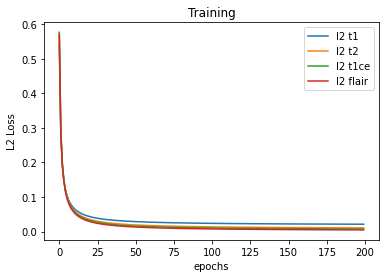

In [33]:
plt.plot(ep_l2_train_loss_t1,      label = 'l2 t1')
plt.plot(ep_l2_train_loss_t2,      label = 'l2 t2')
plt.plot(ep_l2_train_loss_t1ce,    label = 'l2 t1ce')
plt.plot(ep_l2_train_loss_flair,   label = 'l2 flair')
plt.title('Training')
plt.xlabel('epochs')
plt.ylabel('L2 Loss')
plt.legend(loc=1)
plt.show()

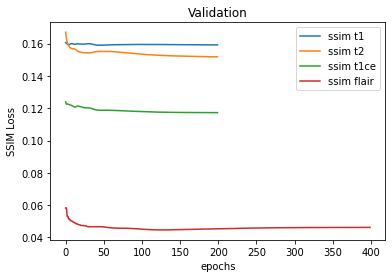

In [37]:
plt.plot(ep_ssim_val_loss_t1,      label = 'ssim t1')
plt.plot(ep_ssim_val_loss_t2,      label = 'ssim t2')
plt.plot(ep_ssim_val_loss_t1ce,    label = 'ssim t1ce')
plt.plot(ep_ssim_val_loss_flair,   label = 'ssim flair')
plt.title('Validation')
plt.xlabel('epochs')
plt.ylabel('SSIM Loss')
plt.legend(loc=1)
plt.show()

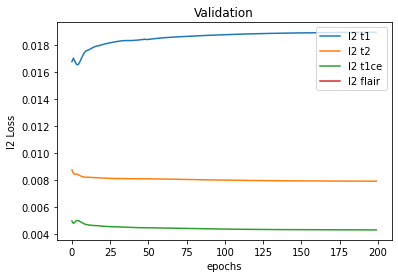

In [35]:
plt.plot(ep_l2_val_loss_t1,      label = 'l2 t1')
plt.plot(ep_l2_val_loss_t2,      label = 'l2 t2')
plt.plot(ep_l2_val_loss_t1ce,    label = 'l2 t1ce')
plt.plot(ep_l2_val_loss_flair,   label = 'l2 flair')
plt.title('Validation')
plt.xlabel('epochs')
plt.ylabel('l2 Loss')
plt.legend(loc=1)
plt.show()